In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import IPython
import tensorflow as tf
from keras.layers import Conv2D, Conv2DTranspose
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import tensorflow_datasets as tfds
import pathlib
import numpy as np
from skimage import io
from skimage.util import random_noise

In [11]:
batch_size    =  32
latent_dim    =  512
epochs        =  20
fit_verbosity =  1
data_dir      = 'drive/MyDrive/datascience/dataset_1/Photo/*'

In [4]:
import cv2
import glob

def load_images(image_size):
  images_ds = np.array([
      cv2.resize(cv2.imread(file), (image_size, image_size))
      for file in glob.glob(data_dir)
    ])
  images_ds = (images_ds - np.min(images_ds)) / (np.max(images_ds) - np.min(images_ds))
  print("Done.")
  return images_ds

# images_ds_128 = load_images(128)[:2000]
images_ds_256 = load_images(256)[:700]

Done.


In [10]:
import csv

a = images_ds_128

with open('drive/MyDrive/datascience/images_128.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(a)

In [5]:
import matplotlib.pyplot as plt
#Show images
def show_images(X, n):
    plt.figure(figsize=(30, 30))
  
    for i in range(n):
        ax = plt.subplot(6, 6, i+1)
        img = np.flip(X[i], axis=-1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

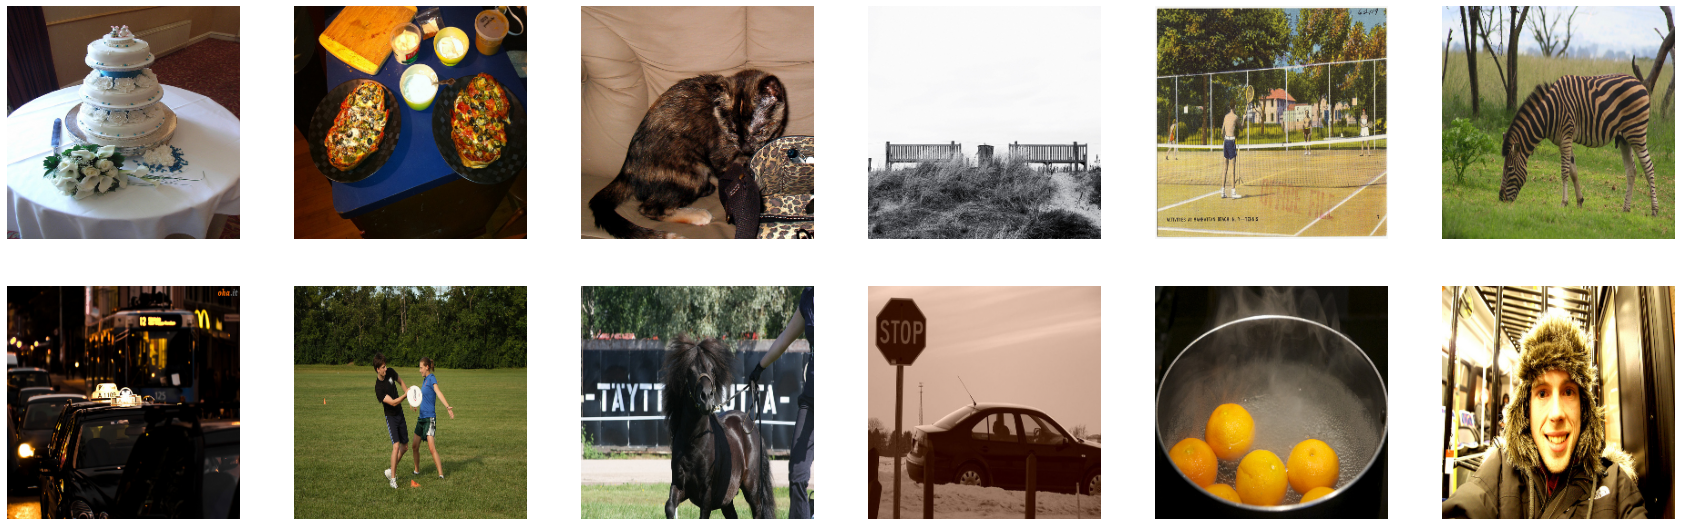

In [7]:
show_images(images_ds_128, n=12)

In [6]:
def noise_it(data):
    new_data = np.copy(data)
    for i, image in enumerate(new_data):
        image=random_noise(image, mode='gaussian', mean=0, var=0.01)
        # image=random_noise(image, mode='s&p',      amount=0.2, salt_vs_pepper=0.5)
        # image=random_noise(image, mode='poisson')
        # image=random_noise(image, mode='speckle',  mean=0, var=0.1)
        new_data[i]=image
    print('Done.')
    return new_data

# ---- Add noise to input data : x_data
#
# noisy_images_ds_128 = noise_it(images_ds_128)
noisy_images_ds_256 = noise_it(images_ds_256)

Done.


In [9]:
show_images(noisy_images_ds_256, n=12)

Output hidden; open in https://colab.research.google.com to view.

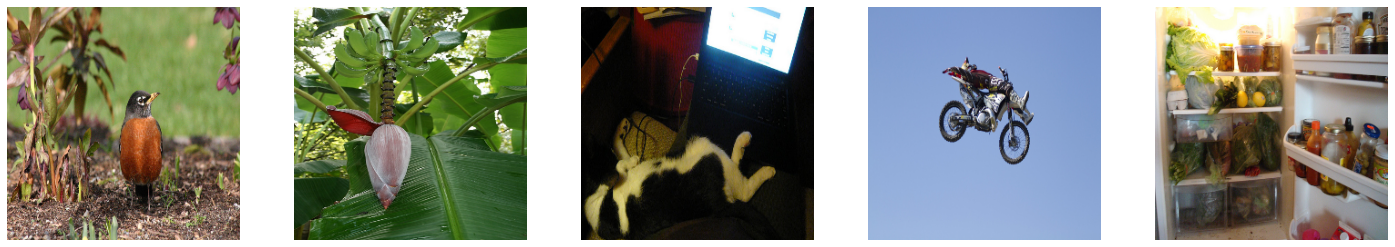

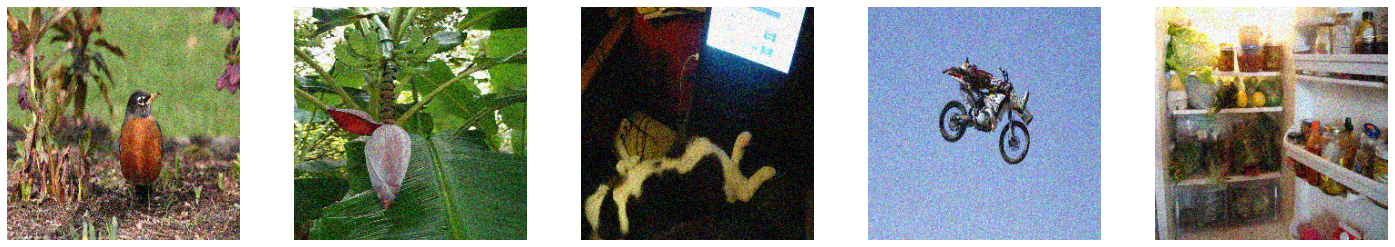

In [7]:
from sklearn.model_selection import train_test_split

# train_dataset_128,       test_dataset_128       = train_test_split(images_ds_128,test_size=0.2, shuffle=False)
# train_dataset_noisy_128, test_dataset_noisy_128 = train_test_split(noisy_images_ds_128,test_size=0.2, shuffle=False)

train_dataset_256,       test_dataset_256       = train_test_split(images_ds_256,test_size=0.2, shuffle=False)
train_dataset_noisy_256, test_dataset_noisy_256 = train_test_split(noisy_images_ds_256,test_size=0.2, shuffle=False)

show_images(test_dataset_256, n=5)
show_images(test_dataset_noisy_256, n=5)

# Model

In [8]:
def model_builder(hp, size):

  # x---------------------x
  # ENCODER

  latent_dim             =  hp.Int(name="latent_dim", min_value=256, max_value=1024)
  print(latent_dim)
  #convolution_filters    =  hp.Int(name='convolution_filters', min_value=2, max_value=4)
  #hidden_layers_neurons  =  hp.Choice('hidden_layers_neurons', [64, 128, 256])

  inputs                 =  keras.Input(shape=(size, size, 3))
  #x = inputs
  # filter = 16
  # for convolution_filter in range(convolution_filters):
  #     x = Conv2D(filter, 3, strides=2, activation='relu', padding='same')(x)
  #     filter*=2
  x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
  x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)

  x          = layers.Flatten()(x)
  #x          = layers.Dense(hidden_layers_neurons, activation="relu")(x)
  x          = layers.Dense(latent_dim * 2, activation="relu")(x)
  z          = layers.Dense(latent_dim)(x)

  encoder    = keras.Model(inputs, z, name="encoder")

  #encoder.summary()


  # x---------------------x
  # DECODER

  decoder_size =   int(size / 4)

  inputs       =   keras.Input(shape=(latent_dim))
  # x            =   layers.Dense(decoder_size * decoder_size * hidden_layers_neurons, activation="relu")(inputs)
  # x            =   layers.Reshape((decoder_size, decoder_size, hidden_layers_neurons))(x)

  # filter = 16 * (convolution_filters - 2)
  # for convolution_filter in range(convolution_filters - 1):
  #     x = Conv2DTranspose(filter, 3, activation='relu', strides=2, padding='same')(x)
  #     filter/=2

  x            =   layers.Dense(decoder_size * decoder_size * 64, activation="relu")(inputs)
  x            =   layers.Reshape((decoder_size, decoder_size, 64))(x)
  x            =   layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
  x            =   layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)

  outputs      =   layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
  decoder      =   keras.Model(inputs, outputs, name="decoder")

  #decoder.summary()


  # x---------------------x
  # AUTOENCODER

  inputs    = keras.Input(shape=(size, size, 3))

  latents   = encoder(inputs)
  outputs   = decoder(latents)

  ae        = keras.Model(inputs, outputs, name="ae")

  loss_function     = hp.Choice('loss_function',     ['binary_crossentropy', 'hinge', 'squared_hinge'])
  optimizer         = hp.Choice('optimizer',         ['adam', 'adamax', 'sgd'])

  ae.compile(loss=loss_function,
                  optimizer=optimizer,
                  metrics='accuracy')

  return ae

In [9]:
def model_builder_128(hp):
    model = model_builder(hp, 128)
    return model

def model_builder_256(hp):
    model = model_builder(hp, 256)
    return model

# 128 TUNER

In [10]:
pip install -q keras_tuner

     |████████████████████████████████| 135 kB 7.8 MB/s 
     |████████████████████████████████| 1.6 MB 53.7 MB/s 


In [11]:
import keras_tuner as kt


tuner_128 = kt.Hyperband(hypermodel = model_builder_128,
                     objective = kt.Objective("val_accuracy", direction="max"),
                     max_epochs = 15,
                     hyperband_iterations=20,
                     project_name='ae_project',)

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)



tuner_128.search(x = train_dataset_noisy_128,
             y = train_dataset_128,
             validation_data=(test_dataset_noisy_128, test_dataset_128),
             epochs=15,
             shuffle=True,
             verbose=1,
             initial_epoch=0,
             callbacks=[ClearTrainingOutput()],
             use_multiprocessing=True,
             workers=6,
             batch_size=batch_size)

# Get the optimal hyperparameters
best_hps_128=tuner_128.get_best_hyperparameters(num_trials=1)[0]

print("x---------------------------x")
print(best_hps_128.values)

Trial 134 Complete [00h 00m 22s]
val_accuracy: 0.45770323276519775

Best val_accuracy So Far: 0.565208911895752
Total elapsed time: 01h 08m 43s

Search: Running Trial #135

Value             |Best Value So Far |Hyperparameter
772               |360               |latent_dim
binary_crossent...|binary_crossent...|loss_function
adam              |adam              |optimizer
5                 |15                |tuner/epochs
2                 |0                 |tuner/initial_epoch
2                 |0                 |tuner/bracket
1                 |0                 |tuner/round
0129              |None              |tuner/trial_id

772
Epoch 3/5
 6/50 [==>...........................] - ETA: 3s - loss: 0.6922 - accuracy: 0.3202

50/50 [==============================] - 12s 222ms/step - loss: 0.6712 - accuracy: 0.4236 - val_loss: 0.6519 - val_accuracy: 0.4455
Epoch 4/5
50/50 [==============================] - ETA: 0s - loss: 0.6426 - accuracy: 0.4409

ResourceExhaustedError: ignored

In [14]:
model_128 = tuner_128.hypermodel.build(best_hps_128)

# 256 TUNER

In [15]:
# import keras_tuner as kt
#
# tuner_256 = kt.Hyperband(hypermodel = model_builder_256,
#                      objective = kt.Objective("val_accuracy", direction="max"),
#                      max_epochs = 15,
#                      hyperband_iterations=20,
#                      project_name='ae_project',)
#
# class ClearTrainingOutput(tf.keras.callbacks.Callback):
#     def on_train_end(*args, **kwargs):
#         IPython.display.clear_output(wait = True)
#
#
#
# tuner_256.search(x = train_dataset_noisy_256,
#              y = train_dataset_256,
#              validation_data=(test_dataset_noisy_256, test_dataset_256),
#              epochs=15,
#              shuffle=True,
#              verbose=1,
#              initial_epoch=0,
#              callbacks=[ClearTrainingOutput()],
#              use_multiprocessing=True,
#              workers=6,
#              batch_size=batch_size)
#
# # Get the optimal hyperparameters
# best_hps_256=tuner_256.get_best_hyperparameters(num_trials=1)[0]
#
# print("x---------------------------x")
# print(best_hps_256.values)

In [16]:
# model_256 = tuner_256.hypermodel.build(best_hps_256)

# EXEMPLE

In [16]:
# Visualisation des pertes d'apprentisstopage (Train) et de validation (Test)
plt.plot(model_128.history['accuracy'], #A COMPLETER
         label='train')
plt.plot(model_128.history['val_accuracy'], #A COMPLETER
         label='test')
plt.legend()

In [ ]:
result = model_128.predict(test_dataset_noisy_128)
show_images(test_dataset_128,5)
show_images(test_dataset_noisy_128, 5)
show_images(result,5)

# MODEL

In [12]:
inputs    = keras.Input(shape=(256, 256, 3))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(latent_dim * 2, activation="relu")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 flatten_1 (Flatten)         (None, 262144)            0         
                                                                 
 dense_3 (Dense)             (None, 1024)              268436480 
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
Total params: 268,980,672
Trainable params: 268,980,672
Non

In [13]:
inputs  = keras.Input(shape=(latent_dim))
x       = layers.Dense(64 * 64 * 64, activation="relu")(inputs)
x       = layers.Reshape((64, 64, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_5 (Dense)             (None, 262144)            134479872 
                                                                 
 reshape_1 (Reshape)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 128, 128, 64)     36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 256, 256, 32)     18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 256, 256, 3)      867 

In [14]:
inputs    = keras.Input(shape=(256, 256, 3))

latents   = encoder(inputs)
outputs   = decoder(latents)

ae = keras.Model(inputs,outputs, name="ae")

ae.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics='accuracy')

In [15]:
history = ae.fit(train_dataset_noisy_256, train_dataset_256,
                 batch_size      = batch_size,
                 epochs          = epochs,
                 verbose         = fit_verbosity,
                 shuffle         = True,
                 validation_data = (test_dataset_noisy_256, test_dataset_256))

Epoch 1/20
18/18 [==============================] - 16s 291ms/step - loss: 0.6875 - accuracy: 0.4040 - val_loss: 0.6868 - val_accuracy: 0.4642
Epoch 2/20
18/18 [==============================] - 4s 216ms/step - loss: 0.6729 - accuracy: 0.4524 - val_loss: 0.6642 - val_accuracy: 0.4605
Epoch 3/20
18/18 [==============================] - 4s 219ms/step - loss: 0.6505 - accuracy: 0.4350 - val_loss: 0.6560 - val_accuracy: 0.4302
Epoch 4/20
18/18 [==============================] - 4s 216ms/step - loss: 0.6330 - accuracy: 0.4186 - val_loss: 0.6374 - val_accuracy: 0.4433
Epoch 5/20
18/18 [==============================] - 4s 216ms/step - loss: 0.6176 - accuracy: 0.4597 - val_loss: 0.6305 - val_accuracy: 0.4519
Epoch 6/20
18/18 [==============================] - 4s 216ms/step - loss: 0.6098 - accuracy: 0.4522 - val_loss: 0.6209 - val_accuracy: 0.4412
Epoch 7/20
18/18 [==============================] - 4s 216ms/step - loss: 0.6024 - accuracy: 0.4490 - val_loss: 0.6175 - val_accuracy: 0.4485
Epoch

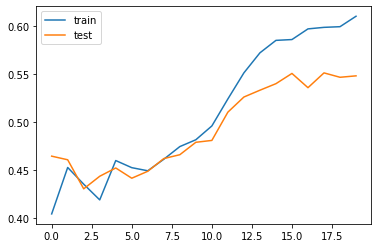

In [16]:
# Visualisation des pertes d'apprentisstopage (Train) et de validation (Test)
plt.plot(history.history['accuracy'], #A COMPLETER
         label='train')
plt.plot(history.history['val_accuracy'], #A COMPLETER
         label='test')
plt.legend()

In [17]:
result = ae.predict(test_dataset_noisy_256)
show_images(test_dataset_256,5)
show_images(test_dataset_noisy_256, 5)
show_images(result,5)

Output hidden; open in https://colab.research.google.com to view.